In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
#Перегляд загального формату даних
data_main = pd.read_csv("df.csv", index_col=False)
data_main.head()

,Unnamed: 0,date,category_id,sku_id,sales_price,sales_quantity
0,78161,2016-11-25,7,1108,457.60,1.0
1,81079,2016-11-18,7,2999,470.60,1.0
2,81177,2016-11-18,7,1428,717.60,1.0
3,81292,2016-11-18,7,3923,383.50,1.0
4,81416,2016-11-18,17,8075,18.85,2.0


In [3]:
# date має формат object а не datetime
data_main.dtypes

Unnamed: 0          int64
date               object
category_id         int64
sku_id              int64
sales_price       float64
sales_quantity    float64
dtype: object

In [4]:
data = data_main.copy()

In [5]:
#видалення колонки індексу та перевод дати у формат datetime 
data.drop("Unnamed: 0", axis=1, inplace=True)
data.drop_duplicates(inplace=True)
data['date'] = pd.to_datetime(data['date'])

In [6]:
# виводимо основні описові статистики, та вже бачимо проблему викидів у колонках sales_price, та sales_quantity
data.describe()

,category_id,sku_id,sales_price,sales_quantity
count,226486.000000,226486.000000,226486.000000,226486.000000
mean,15.069594,497813.898607,109.033102,16.078857
std,4.625731,242446.818578,151.500911,184.248121
min,7.000000,1045.000000,1.027000,1.000000
25%,17.000000,398064.000000,38.220000,1.000000
50%,17.000000,550996.000000,51.350000,3.000000
75%,17.000000,702116.000000,71.500000,5.000000
max,23.000000,838924.000000,2923.700000,8069.000000


In [7]:
def remove_outliers(df: pd.DataFrame, column_name: str) ->  pd.DataFrame:
    """
    Функція для очищення викидів.

    Inputs:
    df (pandas.DataFrame): Датафрейм.
    column_name (str): Назва колонки для очищення.

    Output:
    pandas.DataFrame: Датафрейм з очищеною колонкою від викидів.
    """
    
    quantile_threshold = df[column_name].quantile(0.95)
    df_cleaned = df[df[column_name] <= quantile_threshold]

    return df_cleaned

In [8]:
# чистимо колонки від викидів та перевіряємо 
data = remove_outliers(data, 'sales_quantity')
data = remove_outliers(data, 'sales_price')
data.describe()

,category_id,sku_id,sales_price,sales_quantity
count,204616.000000,204616.000000,204616.000000,204616.000000
mean,15.266919,505878.234786,85.954145,3.616242
std,4.339459,236838.629889,90.335607,3.074446
min,7.000000,1045.000000,2.327000,1.000000
25%,17.000000,415510.000000,38.220000,1.000000
50%,17.000000,558924.000000,50.505000,3.000000
75%,17.000000,702118.000000,67.522000,5.000000
max,23.000000,838924.000000,436.462000,15.000000


In [9]:
data['category_id'].value_counts()

17    153796
7      41221
23      9599
Name: category_id, dtype: int64

In [10]:
data['sku_id'].value_counts()

493549    1373
325766    1358
663873    1343
610642    1338
325774    1332
          ... 
752710       1
588775       1
55195        1
500673       1
824359       1
Name: sku_id, Length: 836, dtype: int64

In [19]:
def create_features(df: pd.DataFrame, label: str = None) -> pd.DataFrame:
    """
    Функція для створення нових ознак 

    Inputs:
    df (pd.DataFrame): Вхідний датафрейм.
    label (str, optional): Назва стовпця, який є цільовою змінною.

    Output:
    pd.DataFrame: DataFrame з новими стовпцями ознак.
    
    """  
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','dayofmonth','weekofyear', 'category_id', 'sales_price']]
    if label:
        y = df[label]
        return X, y
    return X

In [20]:
def visualize_correlation(df):
    """
    Візуалізація кореляції змінних

    Input:
    df (pd.DataFrame): Вхідний датафрейм з даними.

    Output:
    None
    """
    
    corr_matrix = df.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

    threshold = 0.5
    correlated_pairs = corr_matrix.unstack().sort_values().drop_duplicates()
    strong_correlations = correlated_pairs[(correlated_pairs.abs() > threshold) & (correlated_pairs.abs() < 1)]
    print("Strong Correlations (> {:.1f} or < -{:.1f}):\n{}".format(threshold, threshold, strong_correlations))


In [21]:
#генеруємо фічі та ділемо датасет на тренувальний і валідаційний 
X, y = create_features(data, label='sales_quantity')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/p6/py2s90y90vvchwh6r14tzkf00000gn/T/ipykernel_69005/3707520727.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


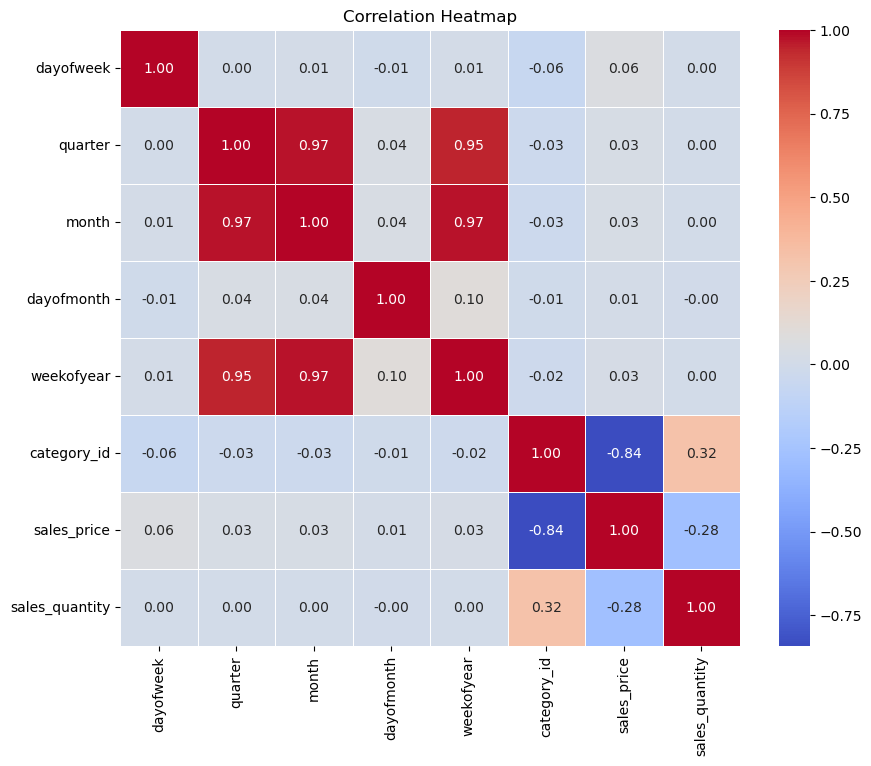

Strong Correlations (> 0.5 or < -0.5):
sales_price  category_id   -0.842006
weekofyear   quarter        0.949041
quarter      month          0.971604
month        weekofyear     0.973166
dtype: float64


In [22]:
# Переглядаємо кореляції ознак між собою та таргетом, з таргетом найбільше корелюють sales_price та category_id
visualize_correlation(pd.concat([X, y], axis=1))

In [23]:
X_train

,dayofweek,quarter,month,dayofmonth,weekofyear,category_id,sales_price
206847,3,2,6,25,26,17,57.122
44391,4,4,12,22,51,17,47.775
124353,3,2,4,4,14,17,53.300
92765,2,4,10,10,41,17,46.800
19971,2,2,4,5,14,17,22.035
...,...,...,...,...,...,...,...
130334,5,2,4,6,14,17,50.635
112750,5,1,2,2,5,17,50.635
143006,5,3,8,24,34,17,57.785
159770,1,4,11,26,48,7,123.487


In [32]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) 

[0]	validation_0-rmse:2.97850	validation_1-rmse:2.97209
[1]	validation_0-rmse:2.92634	validation_1-rmse:2.92089
[2]	validation_0-rmse:2.89907	validation_1-rmse:2.89439
[3]	validation_0-rmse:2.88267	validation_1-rmse:2.87847
[4]	validation_0-rmse:2.87368	validation_1-rmse:2.87049
[5]	validation_0-rmse:2.86805	validation_1-rmse:2.86496
[6]	validation_0-rmse:2.86249	validation_1-rmse:2.86036
[7]	validation_0-rmse:2.85831	validation_1-rmse:2.85719
[8]	validation_0-rmse:2.85546	validation_1-rmse:2.85551
[9]	validation_0-rmse:2.84850	validation_1-rmse:2.85032
[10]	validation_0-rmse:2.84306	validation_1-rmse:2.84684
[11]	validation_0-rmse:2.83857	validation_1-rmse:2.84312
[12]	validation_0-rmse:2.83668	validation_1-rmse:2.84190
[13]	validation_0-rmse:2.83402	validation_1-rmse:2.84051
[14]	validation_0-rmse:2.83116	validation_1-rmse:2.83891
[15]	validation_0-rmse:2.82728	validation_1-rmse:2.83661
[16]	validation_0-rmse:2.82583	validation_1-rmse:2.83654
[17]	validation_0-rmse:2.82387	validation

[144]	validation_0-rmse:2.69106	validation_1-rmse:2.79252
[145]	validation_0-rmse:2.69062	validation_1-rmse:2.79271
[146]	validation_0-rmse:2.68978	validation_1-rmse:2.79294
[147]	validation_0-rmse:2.68889	validation_1-rmse:2.79315
[148]	validation_0-rmse:2.68884	validation_1-rmse:2.79316
[149]	validation_0-rmse:2.68826	validation_1-rmse:2.79302
[150]	validation_0-rmse:2.68802	validation_1-rmse:2.79331
[151]	validation_0-rmse:2.68750	validation_1-rmse:2.79321
[152]	validation_0-rmse:2.68703	validation_1-rmse:2.79317
[153]	validation_0-rmse:2.68665	validation_1-rmse:2.79328
[154]	validation_0-rmse:2.68633	validation_1-rmse:2.79332
[155]	validation_0-rmse:2.68608	validation_1-rmse:2.79341
[156]	validation_0-rmse:2.68551	validation_1-rmse:2.79349
[157]	validation_0-rmse:2.68510	validation_1-rmse:2.79353


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

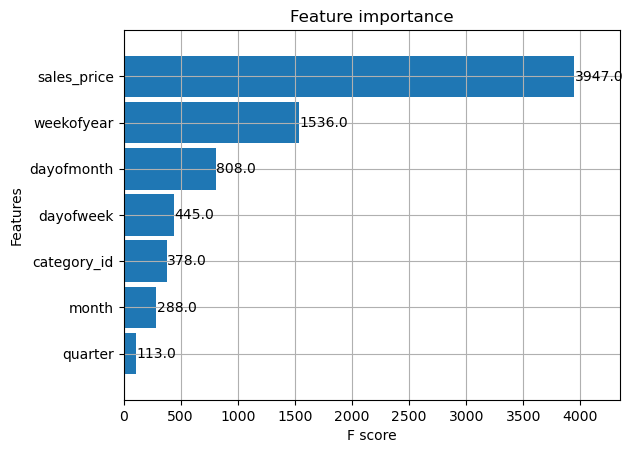

In [26]:
_ = plot_importance(reg, height=0.9)

In [27]:
# підбір кращих параметрів моделі 
param_grid = {
    'n_estimators': [100, 200, 1000],
    'max_depth': [3, 5, 7], 
    'learning_rate': [0.01, 0.1, 0.5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'max_leaves': [4, 6, 10]
}

grid_search = GridSearchCV(reg, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

print("Найкращі параметри:", grid_search.best_params_)
print("Найкраще значення MSE:", -grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error на тестовому наборі:", mse)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Найкращі параметри: {'colsample_bytree': 1.0, 'learning_rate': 0.5, 'max_depth': 3, 'max_leaves': 10, 'n_estimators': 1000, 'subsample': 1.0}
Найкраще значення MSE: 7.869845518666807
Mean Squared Error на тестовому наборі: 7.7760491276873465


In [37]:
reg = xgb.XGBRegressor(n_estimators=1000, colsample_bytree=1, learning_rate=0.5,
                       max_depth=3, max_leaves=10, subsample=1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) 

[0]	validation_0-rmse:2.94421	validation_1-rmse:2.93632
[1]	validation_0-rmse:2.90935	validation_1-rmse:2.90102
[2]	validation_0-rmse:2.89797	validation_1-rmse:2.88967
[3]	validation_0-rmse:2.89355	validation_1-rmse:2.88565
[4]	validation_0-rmse:2.88930	validation_1-rmse:2.88222
[5]	validation_0-rmse:2.88799	validation_1-rmse:2.88097
[6]	validation_0-rmse:2.88479	validation_1-rmse:2.87862
[7]	validation_0-rmse:2.88351	validation_1-rmse:2.87786
[8]	validation_0-rmse:2.88173	validation_1-rmse:2.87669
[9]	validation_0-rmse:2.88096	validation_1-rmse:2.87609
[10]	validation_0-rmse:2.87855	validation_1-rmse:2.87372
[11]	validation_0-rmse:2.87670	validation_1-rmse:2.87203
[12]	validation_0-rmse:2.87480	validation_1-rmse:2.87070
[13]	validation_0-rmse:2.87361	validation_1-rmse:2.86961
[14]	validation_0-rmse:2.87250	validation_1-rmse:2.86877
[15]	validation_0-rmse:2.87106	validation_1-rmse:2.86682
[16]	validation_0-rmse:2.86935	validation_1-rmse:2.86549
[17]	validation_0-rmse:2.86800	validation

[144]	validation_0-rmse:2.80432	validation_1-rmse:2.81338
[145]	validation_0-rmse:2.80418	validation_1-rmse:2.81343
[146]	validation_0-rmse:2.80372	validation_1-rmse:2.81298
[147]	validation_0-rmse:2.80368	validation_1-rmse:2.81298
[148]	validation_0-rmse:2.80361	validation_1-rmse:2.81306
[149]	validation_0-rmse:2.80339	validation_1-rmse:2.81285
[150]	validation_0-rmse:2.80298	validation_1-rmse:2.81273
[151]	validation_0-rmse:2.80276	validation_1-rmse:2.81238
[152]	validation_0-rmse:2.80248	validation_1-rmse:2.81187
[153]	validation_0-rmse:2.80233	validation_1-rmse:2.81182
[154]	validation_0-rmse:2.80225	validation_1-rmse:2.81182
[155]	validation_0-rmse:2.80189	validation_1-rmse:2.81152
[156]	validation_0-rmse:2.80144	validation_1-rmse:2.81123
[157]	validation_0-rmse:2.80132	validation_1-rmse:2.81126
[158]	validation_0-rmse:2.80126	validation_1-rmse:2.81123
[159]	validation_0-rmse:2.80077	validation_1-rmse:2.81074
[160]	validation_0-rmse:2.80060	validation_1-rmse:2.81050
[161]	validati

[286]	validation_0-rmse:2.78414	validation_1-rmse:2.80173
[287]	validation_0-rmse:2.78403	validation_1-rmse:2.80157
[288]	validation_0-rmse:2.78394	validation_1-rmse:2.80163
[289]	validation_0-rmse:2.78389	validation_1-rmse:2.80164
[290]	validation_0-rmse:2.78378	validation_1-rmse:2.80166
[291]	validation_0-rmse:2.78375	validation_1-rmse:2.80167
[292]	validation_0-rmse:2.78368	validation_1-rmse:2.80186
[293]	validation_0-rmse:2.78359	validation_1-rmse:2.80174
[294]	validation_0-rmse:2.78351	validation_1-rmse:2.80180
[295]	validation_0-rmse:2.78336	validation_1-rmse:2.80165
[296]	validation_0-rmse:2.78327	validation_1-rmse:2.80152
[297]	validation_0-rmse:2.78318	validation_1-rmse:2.80140
[298]	validation_0-rmse:2.78311	validation_1-rmse:2.80152
[299]	validation_0-rmse:2.78305	validation_1-rmse:2.80142
[300]	validation_0-rmse:2.78297	validation_1-rmse:2.80139
[301]	validation_0-rmse:2.78277	validation_1-rmse:2.80133
[302]	validation_0-rmse:2.78270	validation_1-rmse:2.80127
[303]	validati

[428]	validation_0-rmse:2.77246	validation_1-rmse:2.79738
[429]	validation_0-rmse:2.77232	validation_1-rmse:2.79714
[430]	validation_0-rmse:2.77226	validation_1-rmse:2.79720
[431]	validation_0-rmse:2.77221	validation_1-rmse:2.79719
[432]	validation_0-rmse:2.77212	validation_1-rmse:2.79719
[433]	validation_0-rmse:2.77208	validation_1-rmse:2.79712
[434]	validation_0-rmse:2.77201	validation_1-rmse:2.79702
[435]	validation_0-rmse:2.77198	validation_1-rmse:2.79702
[436]	validation_0-rmse:2.77194	validation_1-rmse:2.79690
[437]	validation_0-rmse:2.77186	validation_1-rmse:2.79673
[438]	validation_0-rmse:2.77183	validation_1-rmse:2.79673
[439]	validation_0-rmse:2.77180	validation_1-rmse:2.79678
[440]	validation_0-rmse:2.77170	validation_1-rmse:2.79666
[441]	validation_0-rmse:2.77164	validation_1-rmse:2.79675
[442]	validation_0-rmse:2.77149	validation_1-rmse:2.79671
[443]	validation_0-rmse:2.77143	validation_1-rmse:2.79665
[444]	validation_0-rmse:2.77138	validation_1-rmse:2.79668
[445]	validati

[570]	validation_0-rmse:2.76356	validation_1-rmse:2.79335
[571]	validation_0-rmse:2.76352	validation_1-rmse:2.79323
[572]	validation_0-rmse:2.76343	validation_1-rmse:2.79308
[573]	validation_0-rmse:2.76338	validation_1-rmse:2.79305
[574]	validation_0-rmse:2.76331	validation_1-rmse:2.79310
[575]	validation_0-rmse:2.76327	validation_1-rmse:2.79309
[576]	validation_0-rmse:2.76325	validation_1-rmse:2.79304
[577]	validation_0-rmse:2.76322	validation_1-rmse:2.79317
[578]	validation_0-rmse:2.76315	validation_1-rmse:2.79317
[579]	validation_0-rmse:2.76311	validation_1-rmse:2.79319
[580]	validation_0-rmse:2.76308	validation_1-rmse:2.79311
[581]	validation_0-rmse:2.76303	validation_1-rmse:2.79315
[582]	validation_0-rmse:2.76301	validation_1-rmse:2.79313
[583]	validation_0-rmse:2.76298	validation_1-rmse:2.79315
[584]	validation_0-rmse:2.76290	validation_1-rmse:2.79303
[585]	validation_0-rmse:2.76284	validation_1-rmse:2.79285
[586]	validation_0-rmse:2.76277	validation_1-rmse:2.79280
[587]	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=10, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [38]:
predicted = reg.predict(X_test)

In [39]:
# Абсолютна похибка показує нам в середньому відхилення у розмірності нашої цільової змінної 
mean_absolute_error(y_test, predicted)

2.0474321986519017